## Imports

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import seaborn as sns
import matplotlib.pyplot as plt

## Data Import

The training data consists of a short text and binary labels representing human judgments of the emotions in the text. 

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- 6 binary fields representing emotion annotations: joy, fear, anger, sadness, surprise

The data is multilabel, meaning that more than one of the emotion classes may apply to a given text. 

Below we will show you how to load and re-format the provided data file.

In [40]:
# The data contains text and multilabel emotion annotations.
train = pd.read_csv('public_data/train/track_a/eng.csv')

emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

train = train.sample(n=1000, random_state=42).reset_index(drop=True)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['text'].tolist(),
    train[emotions].values,
    test_size=0.3,  # 70/30 split
    random_state=42
    )

## DistilBERT representation

###Tokenization

In [41]:
### Tokenization and Model Initialization
def initialize_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-multilingual-cased", num_labels=len(emotions)
    )
    return tokenizer, model

tokenizer, model = initialize_model_and_tokenizer()

### Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float),
        }

### DataLoaders
batch_size = 16
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Characteristics of the data

Statistics of the data are printed below. There are 2768 samples in the training data. The input representation consists of 29001 input features and there are 5 output clsees. There is an imbalance in the dataset, with the "fear" class being assigned to 58% of samples but the "anger" class to only 12%. 

(Due to the multilabel nature of the data, the percentages do not sum to 1.)

In [42]:
print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")

print(f"Number of positives per emotion class:")
for emotion, count in zip(emotions, train_labels.sum(axis=0)):
    print(f" - {emotion}: {count} ({round(100 * count / len(train_texts), 2)}%)")


Number of training samples: 700
Number of validation samples: 300
Number of positives per emotion class:
 - Joy: 177 (25.29%)
 - Sadness: 223 (31.86%)
 - Surprise: 216 (30.86%)
 - Fear: 405 (57.86%)
 - Anger: 82 (11.71%)


In [43]:
# Calculate weights to handle class imbalance
weights = train_labels.sum(axis=0) / train_labels.sum()
weights = torch.tensor(1 / weights).float()
weights = weights / weights.max()  # Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))

## Train and Evaluate

In [44]:
def train_model(model, train_loader, val_loader, device, epochs=3):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        evaluate_model(model, val_loader, device)

def evaluate_model(model, val_loader, device):
    y_pred, y_true = get_predictions(val_loader, model, device)

    for average in ["micro", "macro"]:
        recall = recall_score(y_true, y_pred, average=average, zero_division=0)
        precision = precision_score(y_true, y_pred, average=average, zero_division=0)
        f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
        print(f"{average.upper()} recall: {recall:.4f}, precision: {precision:.4f}, f1: {f1:.4f}")

def evaluate_per_class(y_true, y_pred):
    for i, emotion in enumerate(emotions):
        print(f"*** {emotion} ***")
        recall = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
        precision = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
        f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        print(f"recall: {recall:.4f}, precision: {precision:.4f}, f1: {f1:.4f}\n")

## Get class predictions

The model outputs logits to coordinate with the BCE. We use a sigmoid transformation to obtain a score in the range of (0,1). We need to define a classification threshold to obtain a binary prediction from the real-valued model output. This can be determined based on the validation data, and may be different for each emotion. Given the imbalance in the data, we set it slightly lower than 0.5 (the standard).

In [45]:
def get_predictions(data_loader, model, device, threshold=0.5):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits) > threshold

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

## Confusion Matrix

In [46]:
def plot_confusion_matrix(y_true, y_pred, class_idx, class_name):
    cm = confusion_matrix(y_true[:, class_idx], y_pred[:, class_idx])
    print(f"Confusion Matrix for {class_name}:")
    print(cm)
    print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")
    print(f"False Negatives: {cm[1, 0]}, True Positives: {cm[1, 1]}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {class_name}")
    plt.show()

## Training and Evaluation

/opt/miniconda3/envs/cs375/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 0.3651
MICRO recall: 0.0000, precision: 0.0000, f1: 0.0000
MACRO recall: 0.0000, precision: 0.0000, f1: 0.0000
Epoch 2, Training Loss: 0.3296
MICRO recall: 0.0000, precision: 0.0000, f1: 0.0000
MACRO recall: 0.0000, precision: 0.0000, f1: 0.0000
Epoch 3, Training Loss: 0.3218
MICRO recall: 0.0000, precision: 0.0000, f1: 0.0000
MACRO recall: 0.0000, precision: 0.0000, f1: 0.0000
Epoch 4, Training Loss: 0.2963
MICRO recall: 0.0022, precision: 0.3333, f1: 0.0045
MACRO recall: 0.0021, precision: 0.0667, f1: 0.0041
Epoch 5, Training Loss: 0.2432
MICRO recall: 0.1345, precision: 0.6316, f1: 0.2218
MACRO recall: 0.1365, precision: 0.6114, f1: 0.2177
Epoch 6, Training Loss: 0.1700
MICRO recall: 0.4148, precision: 0.6314, f1: 0.5007
MACRO recall: 0.3535, precision: 0.5755, f1: 0.4194
Epoch 7, Training Loss: 0.1152
MICRO recall: 0.2601, precision: 0.6203, f1: 0.3665
MACRO recall: 0.2549, precision: 0.5759, f1: 0.3280
Epoch 8, Training Loss: 0.0834
MICRO recall: 0.4507, pr

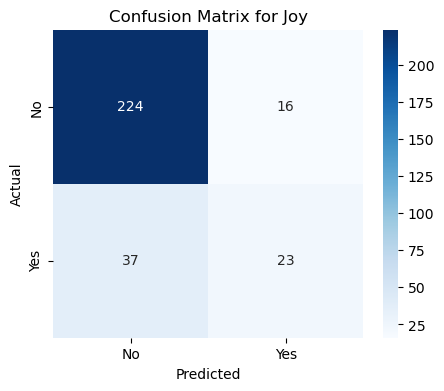

Confusion Matrix for Sadness:
[[185  23]
 [ 65  27]]
True Negatives: 185, False Positives: 23
False Negatives: 65, True Positives: 27


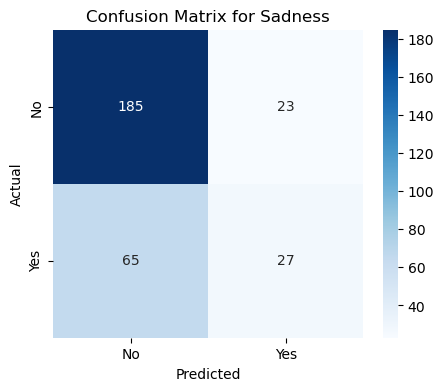

Confusion Matrix for Surprise:
[[161  45]
 [ 32  62]]
True Negatives: 161, False Positives: 45
False Negatives: 32, True Positives: 62


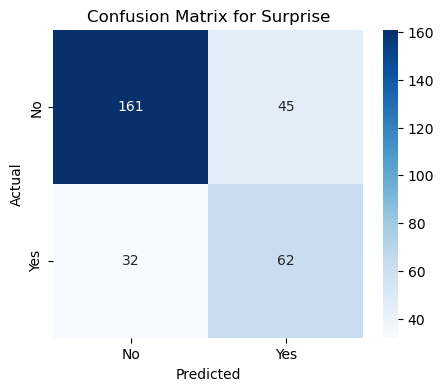

Confusion Matrix for Fear:
[[ 91  39]
 [ 61 109]]
True Negatives: 91, False Positives: 39
False Negatives: 61, True Positives: 109


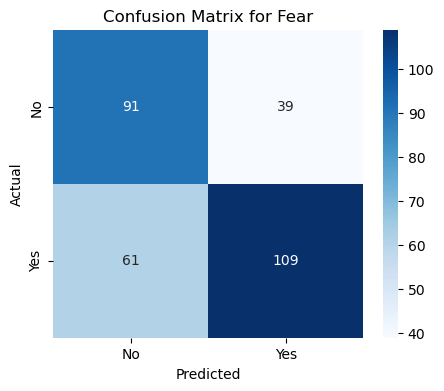

Confusion Matrix for Anger:
[[253  17]
 [ 23   7]]
True Negatives: 253, False Positives: 17
False Negatives: 23, True Positives: 7


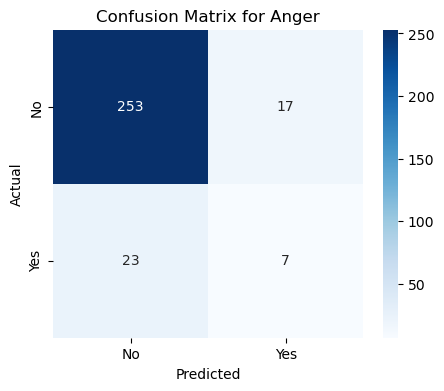

In [47]:
train_model(model, train_loader, val_loader, device, epochs=10)

y_pred, y_true = get_predictions(val_loader, model, device)
print("\n\nEVALUATION\n")
evaluate_model(model, val_loader, device)

print("\nPER CLASS BREAKDOWN\n")
evaluate_per_class(y_true, y_pred)

for i, emotion in enumerate(emotions):
    plot_confusion_matrix(y_true, y_pred, i, emotion)